## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Incorporation of temporal uncertainty

When analyzing paleo environmental data, e.g., relative sea-level (RSL) records, it is important to consider the presence of uncertainties in both the reconstruction of RSL (vertical axis) and the chronology (horizontal axis) of the data. While it is relatively straightforward to incorporate output data uncertainty using variance-weighted Gaussian Process (GP) regression, incorporating chronological uncertainties in GP regression is more challenging.

In this tutorial, we will demonstrate two commonly used methods for incorporating temporal uncertainty in paleo sea-level research:

**&#10148; 1.** Noisy-input Gaussian Process 

**&#10148; 2.** Errors-in-variable Gaussian Process 

Let's start with loading the module and generating some synthetic data:

In [276]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import sys
sys.path.append('../')
import PSTHM 
import time
import seaborn as sns
from scipy import interpolate
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0) #set random seed used in this notebook

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

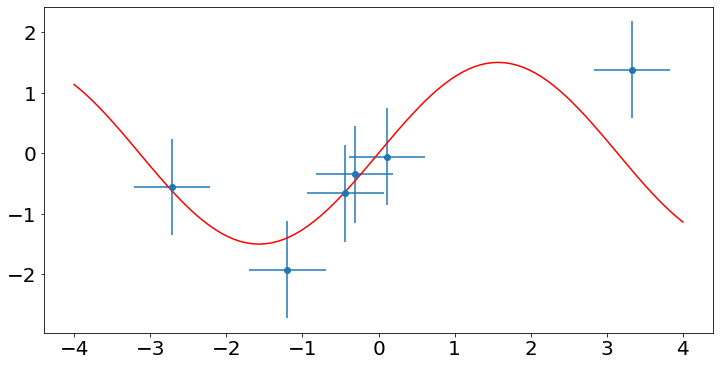

In [391]:
np.random.seed(12345)
x = torch.linspace(-3,3,100)[np.sort(np.random.randint(0,100,6))]
x_full = torch.linspace(-4,4,100)
def f(x):
    return 0+ 1.5*torch.sin(x)
y = f(x)

x_noise = 0.5
y_noise =0.8
x_noisy = x+np.random.normal(0,x_noise,len(x))
y_noisy = y+np.random.normal(0,y_noise,len(y))
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r');

First let's try normal GP without considering the temporal uncertainty:

In [392]:
# Normal GP without considering x error
pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)
gpr = gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print('Length Scale: ',gpr.kernel.lengthscale.item(),'Variance: ',gpr.kernel.variance.item())
#cal misfit

GP_mean, GP_var = gpr(x_full, full_cov=True,noiseless=True)
GP_sd = torch.diag(GP_var).sqrt()  # standard deviation at each input point x


Length Scale:  1.6623887416917869 Variance:  0.4531404168175023


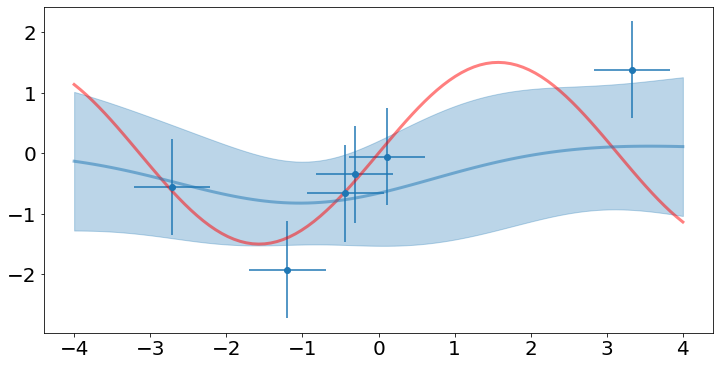

In [393]:
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')

Due to the significant uncertainties present in both the x and y axes of the data, the 95% credible interval obtained using normal Gaussian Process (GP) regression fails to accurately capture the true underlying function within the range of 0 to 2.5.

Now, let's explore the noisy-input GP (NIGP) method. The NIGP method employs a first-order Taylor series approximation, which involves a linear expansion around each input point. This approximation enables the translation of errors in the temporal domain into equivalent errors in the relative sea-level (RSL) domain. Consequently, temporal uncertainty is transformed into RSL uncertainty, which is proportional to the squared gradient of the GP posterior mean.

To implement the NIGP method, we can utilize the gradient of the posterior mean RSL estimation obtained from the normal GP method described earlier. This gradient is used to convert chronological errors into RSL errors, which are then incorporated as new errors for the subsequent GP regression analysis.

In [394]:
# NIGP method
pyro.clear_param_store()

 #-----------------Calculate RSL rate and transferring x error into y error-----------------
x_test = torch.tensor(x.clone().float(),requires_grad=True)
y_mean, y_var = gpr(x_test, full_cov=False)
y_mean.sum().backward(retain_graph=True)
y_rate = x_test.grad.detach().numpy()
new_sigma = np.sqrt(y_rate**2*x_noise**2+y_noise**2)

pyro.clear_param_store()

#generate a RBF kernel 
NI_RBF_kernel = gp.kernels.RBF(input_dim=1)

#generate a GP gression model conditioned on RSL data
NI_gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.tensor(new_sigma**2),jitter=1e-5)
NI_gpr = NI_gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(NI_gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(NI_gpr.model, NI_gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print('Length Scale: ',NI_gpr.kernel.lengthscale.item(),'Variance: ',NI_gpr.kernel.variance.item())


NIGP_matrix = NI_RBF_kernel(x_full,x)@ torch.linalg.inv(NI_RBF_kernel(x,x) + torch.eye(len(x))*y_noise**2 + torch.eye(len(x))*x_noise**2*y_rate**2)
NIGP_mean = NIGP_matrix @y
NIGP_var = NI_RBF_kernel(x_full,x_full) - NIGP_matrix @ NI_RBF_kernel(x,x_full)
NIGP_sd = torch.diag(NIGP_var).sqrt()

Length Scale:  1.6622846550601387 Variance:  0.45613520306618044


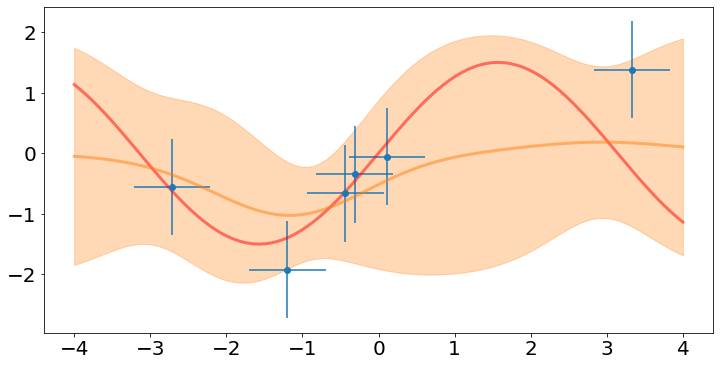

In [395]:
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')


After incorporating the information about chronological errros, the 95% credible interval by NI-GP method succedd in capturing ground truth function in all area. 

An alternative method to incorporate temporal uncertainty is to sample temporal uncertainty directly through errors-in-variable framework using Markov Chain Monte Carlo algorithm (i.e., Fully Bayesian Analysis). Note, it is very important to specify prior distribution for Fully Bayesian Analysis as it directly impact the prediction results. From observing the data above, we can 

In [378]:
# EIV-GP method
from pyro.infer import MCMC, NUTS, HMC
from pyro.contrib.gp.util import conditional

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(10.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1e-3), torch.tensor(3.)))

#generate a GP gression model conditioned on RSL data
EIV_gpr = PSTHM.GPRegression_EIV(x, y, x_noise**2,RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)
EIV_gpr = EIV_gpr.double()

#generate NUTS sampler 
hmc_kernel = NUTS(EIV_gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=1000,warmup_steps=200)
mcmc.run()
mean_lengthscale = mcmc.get_samples()['kernel.lengthscale'].mean()
mean_variance = mcmc.get_samples()['kernel.variance'].mean()
print('Length Scale: ',mean_lengthscale,'Variance: ',mean_variance)


Sample: 100%|██████████| 1200/1200 [00:22, 53.64it/s, step size=6.35e-01, acc. prob=0.889]

Length Scale:  tensor(1.8150) Variance:  tensor(2.7228)


In [379]:
thin_variance = mcmc.get_samples()['kernel.variance']
thin_lengthscale = mcmc.get_samples()['kernel.lengthscale']

from pyro.contrib.gp.util import conditional
EIV_gpr.set_mode("guide")
X_new = x_full
N = EIV_gpr.X.size(0)
N_new = X_new.size(0)
y_residual = EIV_gpr.y - EIV_gpr.mean_function(EIV_gpr.X)
likelihood_list = []
full_bayes_mean,full_bayes_cov = torch.zeros(N_new),torch.zeros(N_new,N_new)
for i in range(len(thin_lengthscale)):
    EIV_gpr.kernel.lengthscale = thin_lengthscale[i]
    EIV_gpr.kernel.vairance = thin_variance[i]
    Kff = EIV_gpr.kernel(EIV_gpr.X).contiguous()
    Kff.view(-1)[:: N + 1] += EIV_gpr.jitter + EIV_gpr.noise  # add noise to the diagonal
    Lff = torch.linalg.cholesky(Kff)
    loc, cov = conditional(
        X_new,
        EIV_gpr.X,
        EIV_gpr.kernel,
        y_residual,
        None,
        Lff,
        True,
        jitter=EIV_gpr.jitter,
    )
    full_bayes_mean +=loc
    full_bayes_cov+=cov
    f_pred = interpolate.interp1d(X_new.detach().numpy(),loc.detach().numpy())
    rsl_pred = f_pred(EIV_gpr.X.detach().numpy())
    likelihood_list.append(PSTHM.cal_likelihood(EIV_gpr.y.detach().numpy(),torch.ones(N)*y_noise,rsl_pred))

full_bayes_mean/=len(thin_lengthscale)
full_bayes_cov/=len(thin_lengthscale)
EIVGP_mean = full_bayes_mean
EIVGP_sd = torch.diag(full_bayes_cov).sqrt()  # standard deviation at each input point x


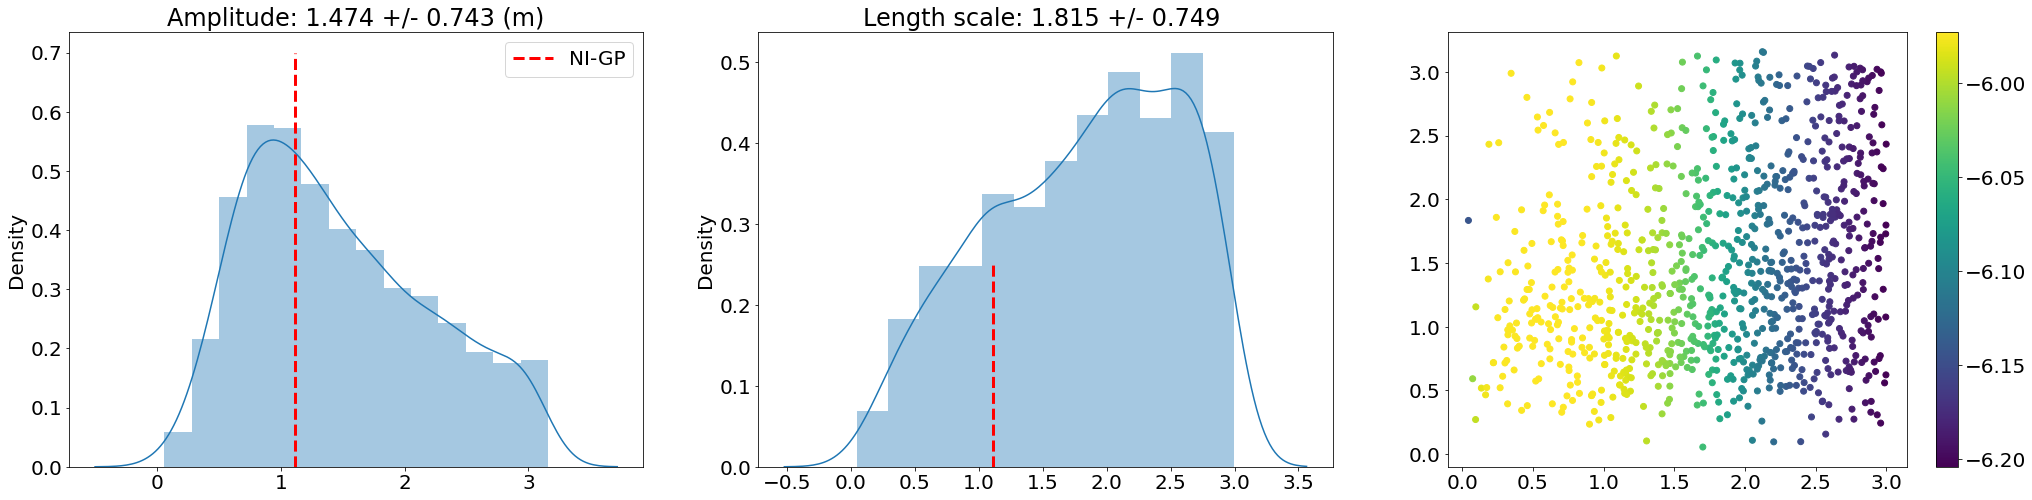

In [380]:
mcmc_variance =mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(35,8))
plt.subplot(131)
sns.distplot(mcmc_variance**0.5)
plt.vlines(NI_gpr.kernel.variance.item()**0.5,0,0.7,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f} (m)'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(132)
sns.distplot(mcmc_lengthscale)
plt.vlines(NI_gpr.kernel.lengthscale.item(),0,0.25,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} '.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)))

plt.subplot(133)
plt.scatter(mcmc_lengthscale,mcmc_variance**0.5,c=likelihood_list)
plt.colorbar();

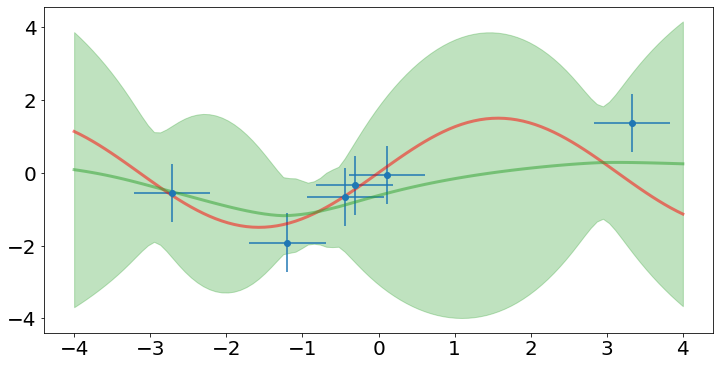

In [381]:
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,EIVGP_mean.detach().numpy()-2*EIVGP_sd.detach().numpy(),EIVGP_mean.detach().numpy()+2*EIVGP_sd.detach().numpy(),alpha=0.3,color='C2',label='EIVGP 95% CI');



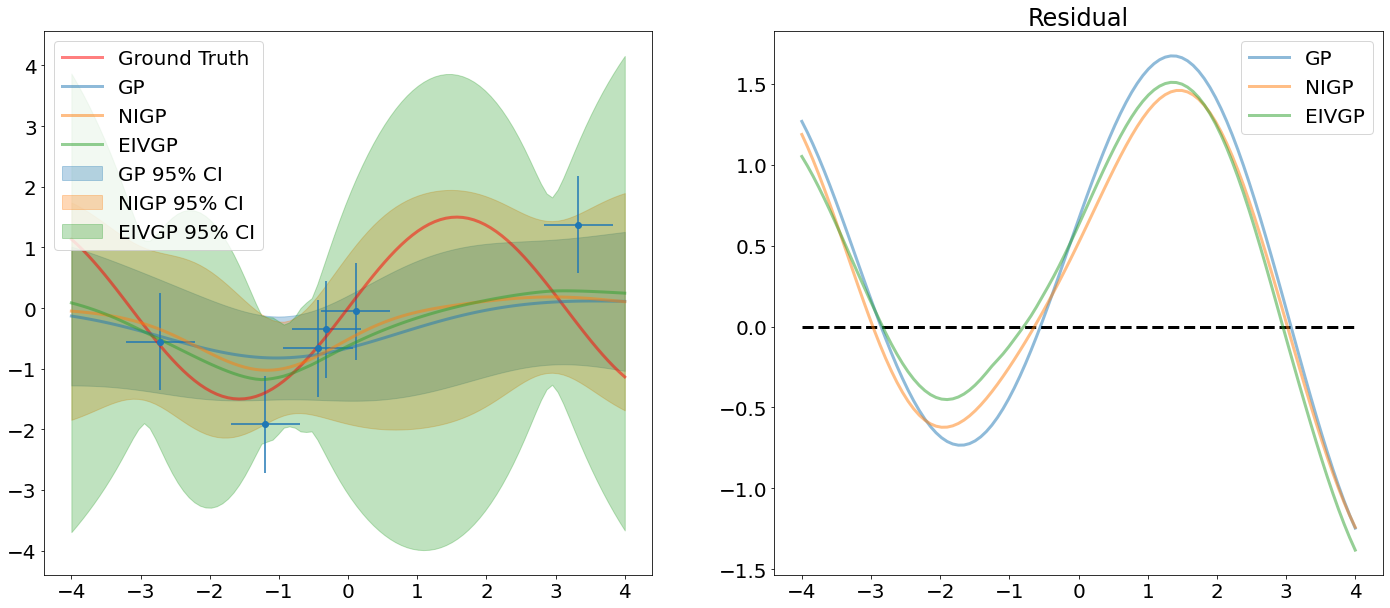

In [382]:
plt.figure(figsize=(24,10))
plt.subplot(121)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)

plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,EIVGP_mean.detach().numpy()-2*EIVGP_sd.detach().numpy(),EIVGP_mean.detach().numpy()+2*EIVGP_sd.detach().numpy(),alpha=0.3,color='C2',label='EIVGP 95% CI')

plt.legend()

plt.subplot(122)
plt.plot(x_full,f(x_full)-GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.hlines(0,-4,4,linewidth=3,linestyles='--',color='k')
plt.title('Residual')
plt.legend();

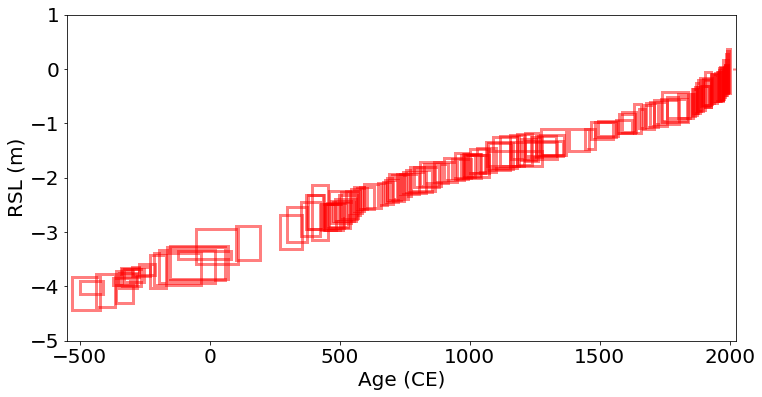

In [496]:
#load data
NJ_data = pd.read_csv('../Data/NJ_CC.csv')
NJ_rsl = NJ_data['RSL']
NJ_rsl_2sd =( NJ_data['RSLer_up_2sd']+NJ_data['RSLer_low_2sd'])/2 #average up and low 2std
NJ_rsl_age = -(NJ_data['Age']-1950) #convert age from BP to CE
NJ_rsl_age_2sd = (NJ_data['Age_low_er_2sd']+NJ_data['Age_up_er_2sd'])/2 #average up and low 2std

#convert RSL data into tonsors
X = torch.tensor(NJ_rsl_age).flatten() #standardise age
y = torch.tensor(NJ_rsl).flatten()
y_sigma = torch.tensor(NJ_rsl_2sd/2).flatten()
x_sigma = torch.tensor(NJ_rsl_age_2sd/2).flatten()

#see the data
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

In [497]:
# Normal GP without considering x error
pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)
gpr = gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print('Length Scale: ',gpr.kernel.lengthscale.item(),'Variance: ',gpr.kernel.variance.item())
#cal misfit
x_full = torch.arange(-550,2025,5)
GP_mean, GP_var = gpr(x_full, full_cov=True,noiseless=True)
GP_sd = torch.diag(GP_var).sqrt()  # standard deviation at each input point x


Length Scale:  611.7513723468863 Variance:  7.31218371797901


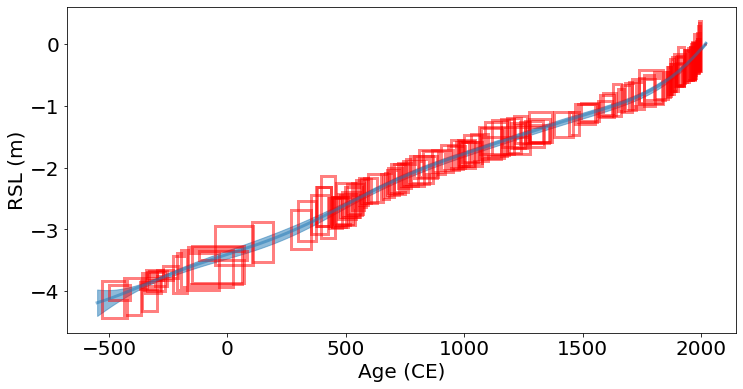

In [498]:
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd)

plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.5,color='C0',label='GP 95% CI')

In [501]:
# NIGP method
pyro.clear_param_store()

 #-----------------Calculate RSL rate and transferring x error into y error-----------------
x_test = torch.tensor(X.clone().double(),requires_grad=True)
y_mean, y_var = gpr(x_test, full_cov=False)
y_mean.sum().backward(retain_graph=True)
y_rate = x_test.grad.detach().numpy()
new_sigma = np.sqrt(y_rate**2*x_sigma.detach().numpy()**2+y_sigma.detach().numpy()**2)

pyro.clear_param_store()

#generate a RBF kernel 
NI_RBF_kernel = gp.kernels.RBF(input_dim=1)

#generate a GP gression model conditioned on RSL data
NI_gpr = PSTHM.GPRegression_V(X, y, NI_RBF_kernel,noise=torch.tensor(new_sigma**2),jitter=1e-5)
NI_gpr = NI_gpr.double()

#optimize RBF kernel with Adam optimizer
optimizer = torch.optim.Adam(NI_gpr.parameters(), lr=0.05)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variance_track,lengthscale_track = [],[]
# likelihoods = []  # List to store the likelihood values
testing_y = []
num_steps = 1000 if not smoke_test else 2

for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(NI_gpr.model, NI_gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print('Length Scale: ',NI_gpr.kernel.lengthscale.item(),'Variance: ',NI_gpr.kernel.variance.item())
x_full = torch.arange(-550,2025,5).double()

NIGP_matrix = NI_RBF_kernel(x_full,X.double()).double()@ torch.linalg.inv(NI_RBF_kernel(X,X) + torch.eye(len(X))*y_sigma**2 + torch.eye(len(X))*x_sigma**2*y_rate**2)
NIGP_mean = NIGP_matrix @y
NIGP_var = NI_RBF_kernel(x_full,x_full) - NIGP_matrix @ NI_RBF_kernel(X.double(),x_full)
NIGP_sd = torch.diag(NIGP_var).sqrt()

Length Scale:  629.9564915638106 Variance:  7.592274813308273


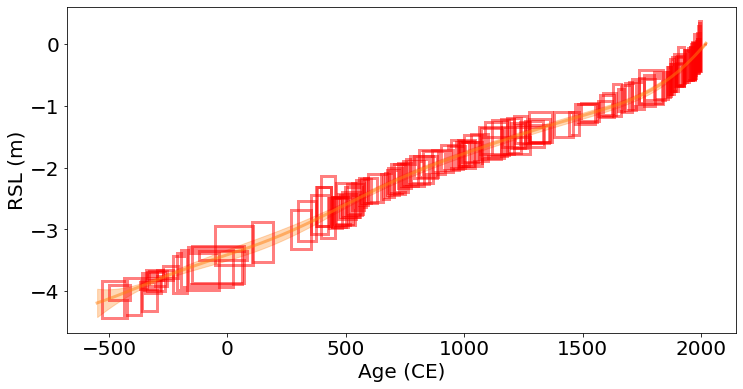

In [502]:
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')


In [515]:
# EIV-GP method
from pyro.infer import MCMC, NUTS, HMC
from pyro.contrib.gp.util import conditional

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(1000.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(3000.)))

#generate a GP gression model conditioned on RSL data
EIV_gpr = PSTHM.GPRegression_EIV(X, y, x_sigma,RBF_kernel,noise=torch.tensor(new_sigma**2),jitter=1e-5)
EIV_gpr = EIV_gpr.double()

#generate NUTS sampler 
hmc_kernel = NUTS(EIV_gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=1000,warmup_steps=200)
mcmc.run()
mean_lengthscale = mcmc.get_samples()['kernel.lengthscale'].mean()
mean_variance = mcmc.get_samples()['kernel.variance'].mean()
print('Length Scale: ',mean_lengthscale,'Variance: ',mean_variance)


Sample: 100%|██████████| 1200/1200 [01:33, 12.83it/s, step size=3.33e-01, acc. prob=0.891]

Length Scale:  tensor(1322.0855, dtype=torch.float64) Variance:  tensor(284.0699, dtype=torch.float64)


In [516]:
thin_variance = mcmc.get_samples()['kernel.variance']
thin_lengthscale = mcmc.get_samples()['kernel.lengthscale']

from pyro.contrib.gp.util import conditional
EIV_gpr.set_mode("guide")
X_new = x_full
N = EIV_gpr.X.size(0)
N_new = X_new.size(0)
y_residual = EIV_gpr.y - EIV_gpr.mean_function(EIV_gpr.X)
likelihood_list = []
full_bayes_mean,full_bayes_cov = torch.zeros(N_new),torch.zeros(N_new,N_new)
for i in range(len(thin_lengthscale)):
    EIV_gpr.kernel.lengthscale = thin_lengthscale[i]
    EIV_gpr.kernel.vairance = thin_variance[i]
    Kff = EIV_gpr.kernel(EIV_gpr.X).contiguous()
    Kff.view(-1)[:: N + 1] += EIV_gpr.jitter + EIV_gpr.noise  # add noise to the diagonal
    Lff = torch.linalg.cholesky(Kff)
    loc, cov = conditional(
        X_new,
        EIV_gpr.X,
        EIV_gpr.kernel,
        y_residual,
        None,
        Lff,
        True,
        jitter=EIV_gpr.jitter,
    )
    full_bayes_mean +=loc
    full_bayes_cov+=cov
    f_pred = interpolate.interp1d(X_new.detach().numpy(),loc.detach().numpy())
    rsl_pred = f_pred(EIV_gpr.X.detach().numpy())
    likelihood_list.append(PSTHM.cal_likelihood(EIV_gpr.y.detach().numpy(),torch.ones(N)*y_noise,rsl_pred))

full_bayes_mean/=len(thin_lengthscale)
full_bayes_cov/=len(thin_lengthscale)
EIVGP_mean = full_bayes_mean
EIVGP_sd = torch.diag(full_bayes_cov).sqrt()  # standard deviation at each input point x


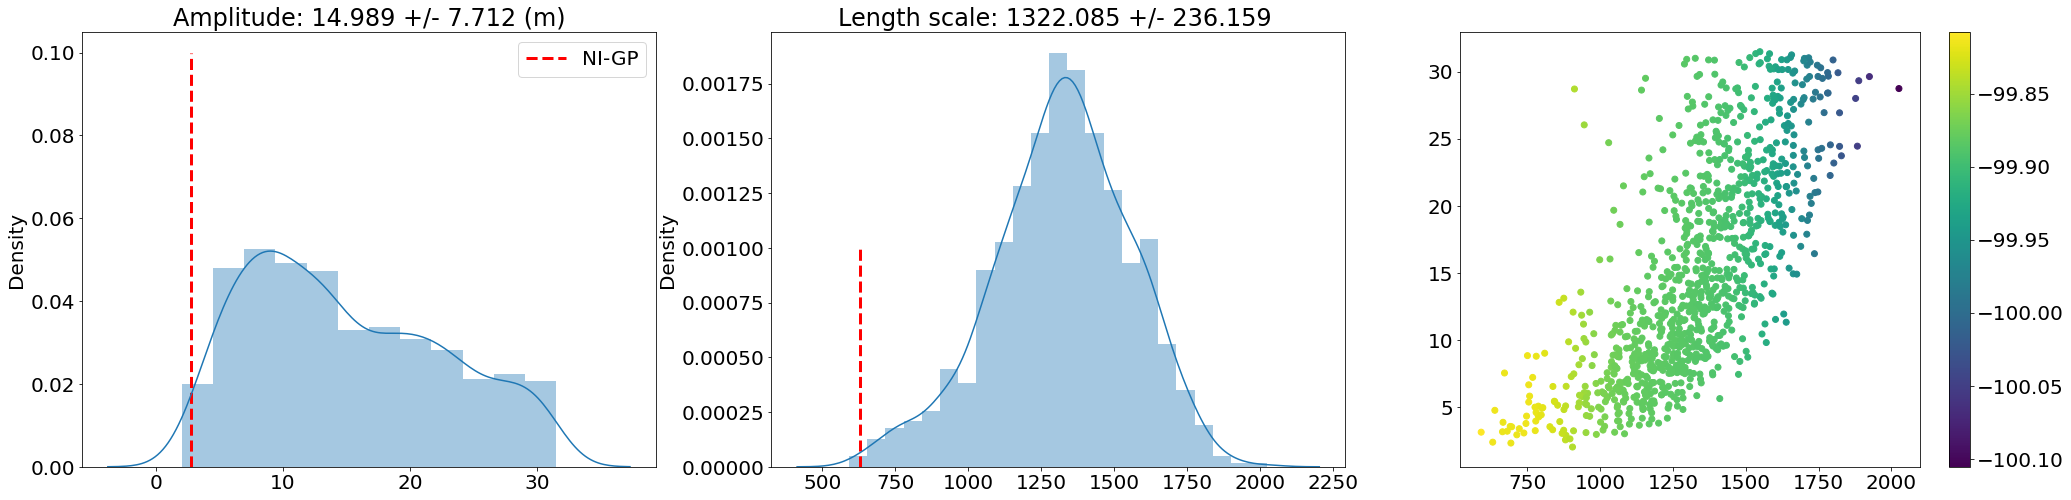

In [517]:
mcmc_variance =mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(35,8))
plt.subplot(131)
sns.distplot(mcmc_variance**0.5)
plt.vlines(NI_gpr.kernel.variance.item()**0.5,0,0.1,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f} (m)'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(132)
sns.distplot(mcmc_lengthscale)
plt.vlines(NI_gpr.kernel.lengthscale.item(),0,0.001,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} '.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)))

plt.subplot(133)
plt.scatter(mcmc_lengthscale,mcmc_variance**0.5,c=likelihood_list)
plt.colorbar();

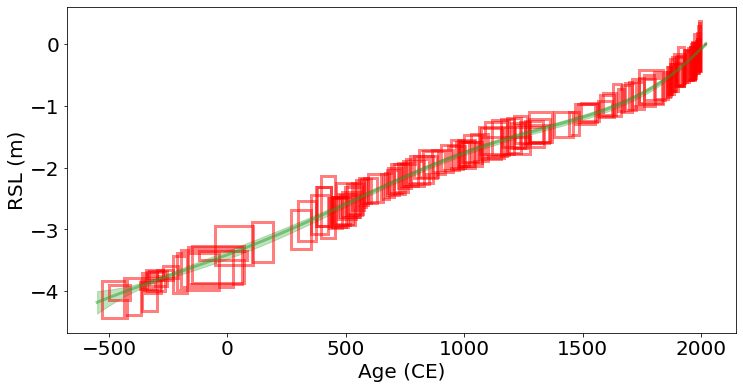

In [518]:
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd)
plt.plot(x_full,EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,EIVGP_mean.detach().numpy()-2*EIVGP_sd.detach().numpy(),EIVGP_mean.detach().numpy()+2*EIVGP_sd.detach().numpy(),alpha=0.3,color='C2',label='EIVGP 95% CI')


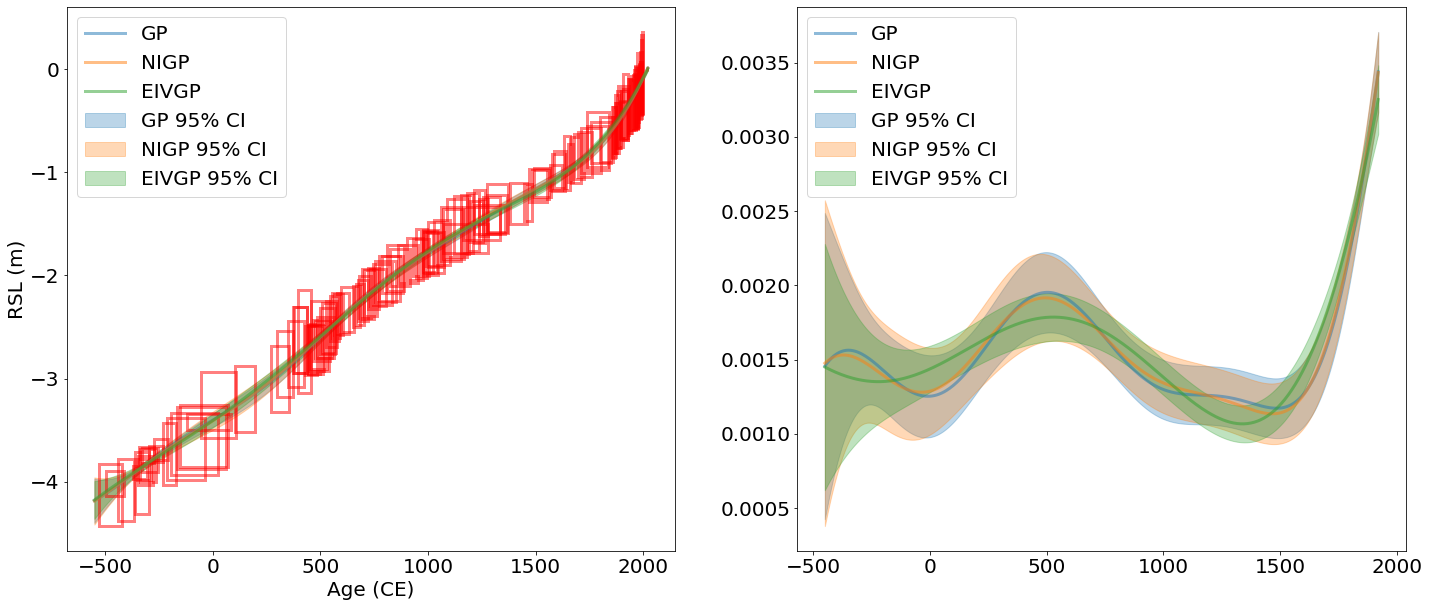

In [526]:
plt.figure(figsize=(24,10))
ax = plt.subplot(121)
ax = PSTHM.plot_uncertainty_boxes(NJ_rsl_age,NJ_rsl, NJ_rsl_age_2sd,NJ_rsl_2sd,ax=ax)

plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean.detach().numpy(),color='C2',label='EIVGP',linewidth=3,alpha=0.5)

plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,EIVGP_mean.detach().numpy()-2*EIVGP_sd.detach().numpy(),EIVGP_mean.detach().numpy()+2*EIVGP_sd.detach().numpy(),alpha=0.3,color='C2',label='EIVGP 95% CI')

plt.legend()

plt.subplot(122)
rsl_time,GP_rate,GP_rate_sd = PSTHM.cal_rate_var(x_full.detach().numpy(),GP_var.detach().numpy(),GP_mean.detach().numpy())
rsl_time,NIGP_rate,NIGP_rate_sd = PSTHM.cal_rate_var(x_full.detach().numpy(),NIGP_var.detach().numpy(),NIGP_mean.detach().numpy())
rsl_time,EIVGP_rate,EIVGP_rate_sd = PSTHM.cal_rate_var(x_full.detach().numpy(),full_bayes_cov.detach().numpy(),full_bayes_mean.detach().numpy())
plt.plot(rsl_time,GP_rate,color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(rsl_time,NIGP_rate,color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(rsl_time,EIVGP_rate,color='C2',label='EIVGP',linewidth=3,alpha=0.5)

plt.fill_between(rsl_time,GP_rate-2*GP_rate_sd,GP_rate+2*GP_rate_sd,alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(rsl_time,NIGP_rate-2*NIGP_rate_sd,NIGP_rate+2*NIGP_rate_sd,alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(rsl_time,EIVGP_rate-2*EIVGP_rate_sd,EIVGP_rate+2*EIVGP_rate_sd,alpha=0.3,color='C2',label='EIVGP 95% CI')
plt.legend()